## Домашнее задание

Урок 4. CNN Свертки
Обучите CNN (самописная) на CIFAR-100.

Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

*Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

# I Обучение самописной модели

## 1 Импорт необходимых библиотек

In [1]:
import os
import time
import torch
import shutil
import numpy as np
from torch import nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.nn import functional as F
from google.colab import files, drive
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

## 2 Загрузка и сохранение датасета cifar100

In [2]:
Data = datasets.CIFAR100(root='data/', train=True, download=True)

100%|██████████| 169001437/169001437 [00:12<00:00, 13370298.65it/s]


Extracting data/cifar-100-python.tar.gz to data/


## 3 Определение собственного класса для хранения датасета

In [4]:
class MyOwnCifar100(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

## 4 Определение трансформаций для объекта (изображения)

In [ ]:
"""Сжатие, обрезка, запись в тензор"""
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])

## 5 Разделение датасета на тренировочный и валидационный

In [ ]:
train_dataset, valid_dataset = train_test_split(Data, test_size=0.05, random_state=13)

## 6 Запись датасета в класс

In [ ]:
train_dataset = MyOwnCifar100(train_dataset, trans_actions)
valid_dataset = MyOwnCifar100(valid_dataset, transforms.ToTensor())

## 7 Определение датасета в Dataloader

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True, num_workers=1)

## 9 Вывод на печать изображения

torch.Size([3, 32, 32])


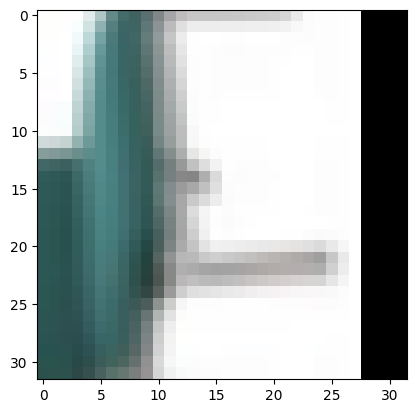

In [ ]:
num_img = 6
for img, lbl in train_loader:
    print(img[0].shape)
    plt.imshow(img[0].permute(2,1,0))
    break

## 10 Проверка подключение к CUDA

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 11 Описание структуры модели

In [ ]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.dp1 = nn.Dropout(0.2)
        self.dp2 = nn.Dropout(0.2)

        """Нормализация на 3 канала"""
        self.bn1 = nn.BatchNorm2d(3)
        """Свертка. Из 3-х каналов пересчитываем на 30(выход)"""
        self.conv1 = nn.Conv2d(3,30,3)
        """Нормализация на 30 каналов"""
        self.bn2 = nn.BatchNorm2d(30)
        """Свертка. Из 30-ти каналов на 60(выход)"""
        self.conv2 = nn.Conv2d(30, 60, 3)
        """Нормализация на 60 каналов"""
        self.bn3 = nn.BatchNorm2d(60)
        """Свертка. Из 60-ти каналов на 120(выход)"""
        self.conv3 = nn.Conv2d(60, 120, 3)
        """Нормализация на 120 каналов"""
        self.bn4 = nn.BatchNorm2d(120)
        """1-й Полносвязный слой"""
        self.fc1 = nn.Linear(480, 320)
        """2-й Полносвязный слой"""
        self.fc2 = nn.Linear(320, 200)
        """3-й Полносвязный слой"""
        self.out = nn.Linear(200, 100)

    def forward(self, x):
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn2(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn3(x)
        x = self.conv3(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)

        x = self.bn4(x)
        x = x.view(x.size(0), -1)
        x = self.dp1(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = F.relu(x)

        return self.out(x)

In [ ]:
model = Model().to(device)
print(model)

Model(
  (dp1): Dropout(p=0.2, inplace=False)
  (dp2): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=100, bias=True)
)


## 12 Определение оптимизатора и функции потерь

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

## 13 Просмотр структуры модели

In [ ]:
summary(model.to(device), input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 320]         153,920
          Dropout-10                  [-1, 320]               0
           Linear-11                  [-1, 200]          64,200
           Linear-12                  [-1, 100]          20,100
Total params: 320,666
Trainable params: 320,666
Non-trainable params: 0
-------------------------------

## 14 Обучение модели

In [3]:
def Model_fit(Model, X, y, model_epochs, model_optimizers, model_losses, logit_step, device):
    Model.train()
    start = time.time()
    train_accuracy_all = []
    train_loss_all = []


    for epoch in range(model_epochs):
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        for i, data in enumerate(X, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # обнуляем градиент
            model_optimizers.zero_grad()

            outputs = Model(inputs)
            loss = model_losses(outputs, labels)
            loss.backward()
            model_optimizers.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            running_right += (labels == torch.max(outputs, 1)[1]).sum()

            # выводим статистику о процессе обучения
            if i % logit_step == 0:    # печатаем каждые 300 mini-batches
                Model.eval()

                print("", end=f'\rEpoch [{epoch + 1}/{model_epochs}]. ' \
                                f'Loss: {running_loss / running_items:.3f}. ' \
                                f'Acc: {running_right / running_items:.3f}. ')

                train_accuracy_all.append(running_right / running_items)
                train_loss_all.append(running_loss / running_items)

                running_loss, running_items, running_right = 0.0, 0.0, 0.0

                test_running_right, test_running_total = 0.0, 0.0
                for i, data in enumerate(y):

                    test_outputs = Model(data[0].to(device))
                    test_running_total += len(data[1])
                    test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

                print("", end=f'Test acc: {test_running_right / test_running_total:.3f}')

            Model.train()

    stop = time.time()
    print(f'\nTraining is finished! It took {round((stop - start), 2)} seconds')
    plt.plot(train_loss_all)
    plt.show()
    return train_accuracy_all, train_loss_all

## 15 Визуализация графика функии потерь

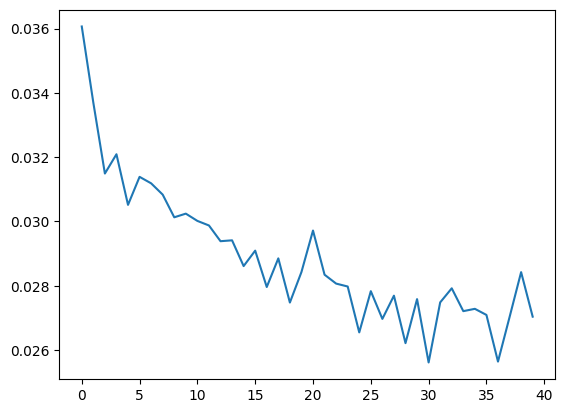

In [ ]:
plt.plot(train_loss_all)
plt.show()

## 16 Сохранение и загрузка модели

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
PATH_DIR = '/content/drive/MyDrive/My_model_3/'
PATH_MODEL = '/content/drive/MyDrive/My_model_3/my_model_cifar100.pth'

In [ ]:
if os.path.exists(PATH_DIR):
    shutil.rmtree(PATH_DIR)
os.makedirs(PATH_DIR)

### 16.1 Сохранение

In [ ]:
torch.save(model, PATH_MODEL)

### 16.2 Загрузка

In [ ]:
my_model = torch.load(PATH_MODEL)

Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

# II Дообучение модели Resnet-50 на Cifar100

## 1 Загрузка модели Resnet-50

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
from torchvision import models

resnet_50 = models.resnet50(pretrained=True)
summary(resnet_50.to(device), input_size=(3,32,32))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

## 2 Блокировка весов на обученой молдели

In [7]:
for param in list(resnet_50.parameters())[:]:
    param.requires_grad = False

## 3 Перезапись последнего(полносвязного слоя)

In [8]:
num_feature = resnet_50.fc.in_features
num_feature

2048

In [9]:
resnet_50.fc = nn.Linear(num_feature, 100)

## 4 Просмотр структуры сети

In [10]:
summary(resnet_50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

## 5 Перемещение модели на графический процессор

In [11]:
resnet_50 = resnet_50.to(device)

## 6 Определение трансформаций для объекта (изображения)

In [12]:
train_actions_50 = transforms.Compose([transforms.Resize(124),
                                    transforms.RandomCrop(96, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

valid_actions_50 = transforms.Compose([transforms.Resize(124),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

## 7 Разделение датасета на тренировочный и валидационный

In [13]:
train_dataset_50, valid_dataset_50 = train_test_split(Data, test_size=0.05, random_state=13)

## 8 Запись датасета в класс

In [14]:
train_dataset_50 = MyOwnCifar100(train_dataset_50, train_actions_50)
valid_dataset_50 = MyOwnCifar100(valid_dataset_50, valid_actions_50)

## 9 Определение датасета в Dataloader

In [15]:
train_loader_50 = torch.utils.data.DataLoader(train_dataset_50, batch_size=128, shuffle=True, num_workers=2)
valid_loader_50 = torch.utils.data.DataLoader(valid_dataset_50, batch_size=128, shuffle=True, num_workers=1)

## 10 Определение оптимизатора и функции потерь

### 10.1 Определение весов для оптимизатора

In [16]:
weights_for_optimizer = []
for _, param in resnet_50.named_parameters():
    if param.requires_grad == True:
        weights_for_optimizer.append(param)

In [17]:
optimizer_50 = torch.optim.Adam(weights_for_optimizer, lr=0.001)
criterion_50 = nn.CrossEntropyLoss()

## 11 Дообучение модели

Epoch [10/10]. Loss: 0.011. Acc: 0.598. Test acc: 0.609
Training is finished! It took 478.52 seconds


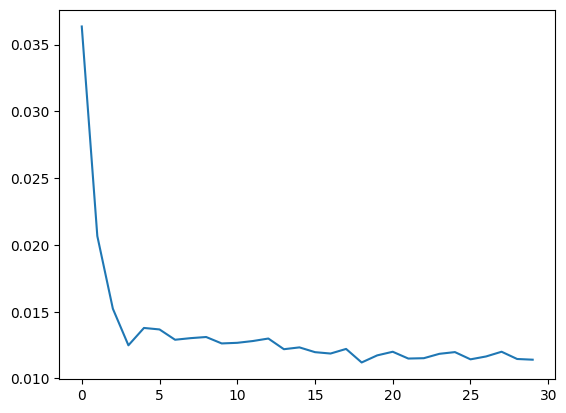

In [19]:
acc, loss = Model_fit(resnet_50, train_loader_50, valid_loader_50, 10, optimizer_50, criterion_50, 150, device)